# 프로젝트 : 고양이 수염 스티커 만들기 

## STEP1. 사진 준비하기 

이미지 처리를 위해 opencv와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어오기

* 편의를 위해 이미지 크기 변경

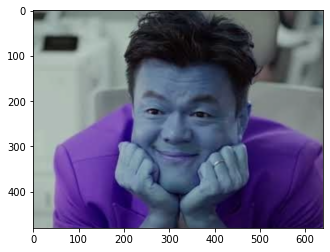

In [ ]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/jyp2.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv의 특징으로 푸른색을 띔

* matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB순으로 사용하지만 opencv는 예외적으로 BGR을 사용하기 때문에 opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색깔 보정 필요 

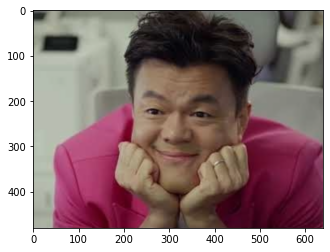

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## STEP2. 얼굴 검출 

Object detection 기술을 이용해서 얼굴의 위치를 찾을 수 있음

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾음

`dlib`을 활용해 `hog detector`를 선언

`detector`를 이용해서 얼굴의 `bounding box`를 추출
* dlib은 rgb 이미지를 입력으로 받기 때문에 `cvtColor()` 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환

* `detector_hog`의 두 번째 파라미터는 이미지 피라미드의 수.

    이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드

    이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능

In [ ]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

찾은 얼굴 출력

rectangles[[(216, 167) (439, 390)]]


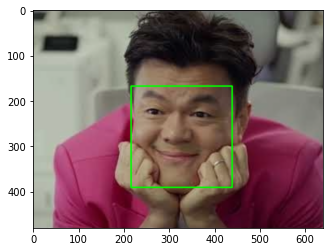

In [ ]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## STEP3. 얼굴 랜드마크

저장된 landmark 모델 불러오기

In [ ]:
import os
model_path = '/content/gdrive/My Drive/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

`landmark_predictor` 는 `RGB 이미지`와 `dlib.rectangle`을 입력 받아 `dlib.full_object_detection` 를 반환

In [ ]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


랜드마크 영상에 출력

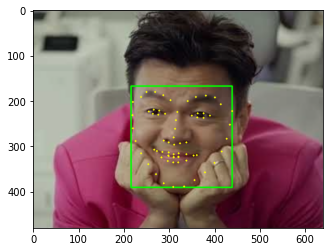

In [ ]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## STEP4. 스티커 적용하기

힌트를 보면 랜드마크 2, 36, 48, 30 인덱스를 사용하라고 했지만 코에 고정하고 refined 하는게 더 잘됨

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (310,280)
(w,h) : (224,224)


In [ ]:
import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(224, 224, 3)


고양이 수염 사진을 bounded box에 맞춰서 resize 했기 때문에 코 좌표인 x에 w//2 해서 refined 해줌 

In [ ]:
refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))

sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

(x, y) : (198, 168)
(224, 224, 3)


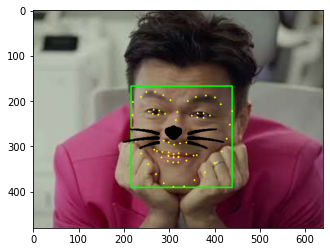

In [ ]:
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

추가적으로 반투명하게 고양이 수염을 적용하려면 addWeighted를 사용해 알파, 베타값을 0.5로 설정하였다.

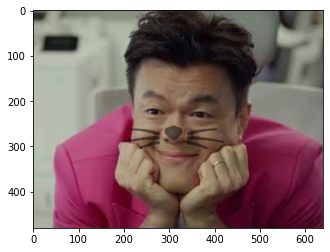

In [ ]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
     cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## STEP5. 문제점 찾아보기 

### 최준

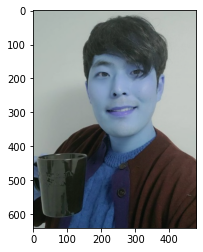

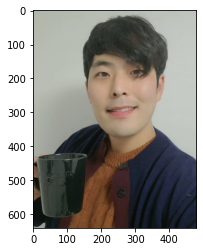

rectangles[[(142, 118) (365, 341)]]


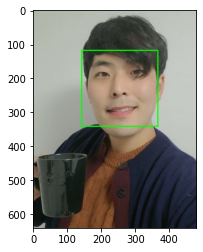

68


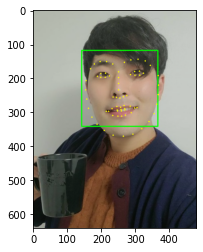

In [ ]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/joon.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(x,y) : (250,234)
(w,h) : (224,224)
(224, 224, 3)
(x, y) : (138, 122)
(224, 224, 3)


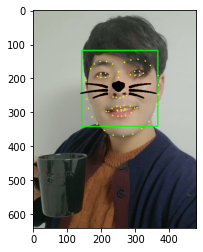

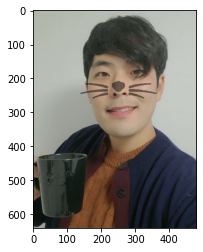

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)

refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 송강 (거리멀때)

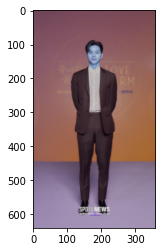

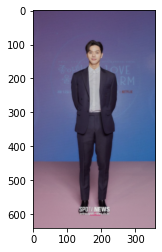

rectangles[[(156, 113) (199, 156)]]


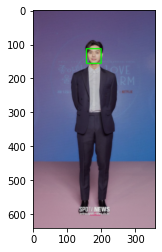

68


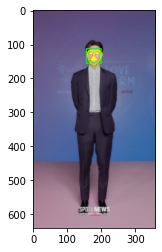

In [ ]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/song_l.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (360, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(x,y) : (177,135)
(w,h) : (44,44)
(44, 44, 3)
0.23579056028370643
(x, y) : (155, 113)
(44, 44, 3)


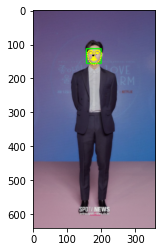

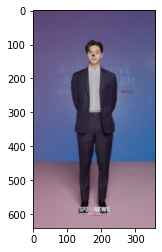

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

v1 = np.array([w, h])
v2 = np.array([landmark[42][0]+ (landmark[42][0]-landmark[48][0])//2, landmark[42][1]+ (landmark[42][1]-landmark[48][1])//2])

v12 = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
angle = np.arccos(v12)
print(angle)

import math
rotate = cv2.getRotationMatrix2D((w/2, h/2), math.degrees(angle), 1)
img_sticker_rotate = cv2.warpAffine(img_sticker, rotate, (w, h), borderValue=(255, 255, 255))
plt.imshow(img_sticker_rotate)
plt.show

plt.imshow(img_sticker_rotate)

refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

img_show[refined_y:refined_y + img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]]
img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


### 한소희 (얼굴각도)

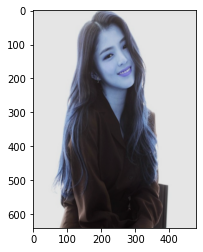

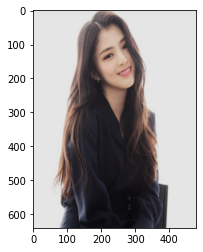

rectangles[[(196, 82) (325, 211)]]


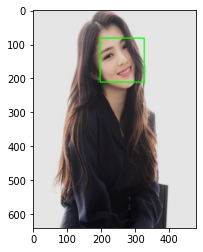

68


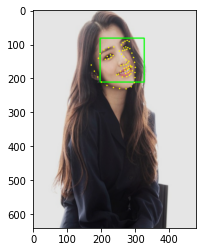

In [ ]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/han.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 각도 해결하기

얼굴이 틀어져 있는 경우를 해결하고 싶어 두 벡터를 지정하고 arccos를 사용해 각도를 구하였다. 
<br>여러 좌표를 v2로 지정해봤는데, 오른쪽 눈머리와 왼쪽 입술 끝 가운데 지점이 가장 좋은 각도가 나왔다. 

In [ ]:
v1 = np.array([w, h])
v2 = np.array([landmark[42][0]+ (landmark[42][0]-landmark[48][0])//2, landmark[42][1]+ (landmark[42][1]-landmark[48][1])//2])

v12 = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
angle = np.arccos(v12)
print(angle)

0.4871595129089828


(44, 44, 3)


<function matplotlib.pyplot.show>

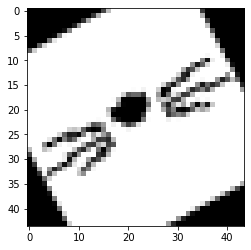

In [ ]:
import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)
rotate = cv2.getRotationMatrix2D((w/2, h/2), math.degrees(angle), 1)
img_sticker_rot = cv2.warpAffine(img_sticker, rotate, (w, h))
plt.imshow(img_sticker_rot)
plt.show

(x,y) : (272,146)
(w,h) : (130,130)
(130, 130, 3)
0.48715951290898324
(x, y) : (207, 81)
(130, 130, 3)


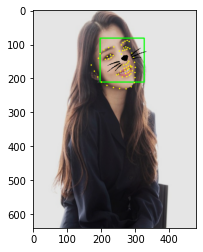

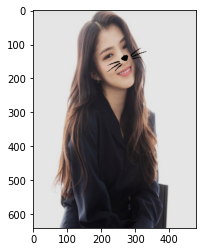

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

v1 = np.array([w, h])
v2 = np.array([landmark[42][0]+ (landmark[42][0]-landmark[48][0])//2, landmark[42][1]+ (landmark[42][1]-landmark[48][1])//2])

v12 = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
angle = np.arccos(v12)
print(angle)

rotate = cv2.getRotationMatrix2D((w/2, h/2), math.degrees(angle), 1)
img_sticker_rotate = cv2.warpAffine(img_sticker, rotate, (w, h), borderValue=(255, 255, 255))
plt.imshow(img_sticker_rotate)
plt.show

plt.imshow(img_sticker_rotate)

refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

img_show[refined_y:refined_y + img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]]
img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


## 회고
배운 내용들을 여러 사진에 적용해보았다. 

landmark를 통해 원하는 위치에 스티커를 붙일 수 있었다는 것이 흥미로웠다. 

각도에 대한 문제는 해결하였지만 촬영 거리가 멀어졌을때는 스티커가 잘 보이지 않았고 사진 자체가 회전되어 있을땐 bounding box자체가 얼굴을 인식하지 못하여 적용하지 못했다. 

누워있는 사진 또한 적용시켜보려했지만 bounding box가 생성되지 않았다. 

하지만 내 기준에 거리가 멀다고 생각했던 송강 얼굴자체의 인식은 잘되어서 인식률이 높다고 생각하였다. 

스티커 사진을 회전시켜 적용하고 싶어 대학생 3학년때 배우던 행렬연산 책을 들여다보며 angle을 구하기위해 arccos를 사용하는 등 많은 시도를 해보았다. 

`cv2.getRotationMatrix2D()`을 사용하여 위에서 구한 각도를 적용시켜 고양이 수염을 회전시켰고, `cv2.warpAffin()`을 통해 회전시킨 이미지를 적용하였다. 

고양이 수염 이미지는 `cv2.addWeighted()`를 통해 반투명하게 적용시킬 수 있었다. 

예전에 배운 개념들을 상기 시키면서 배웠던 개념들을 이렇게 사용할 수 있다는 것에 놀랐고 재미있었다. 

누워있는 사진, 회전된 사진에도 어떻게 하면 적용할 수 있을지 더 고민해보면 좋을 것 같다. 

참고한 링크 

[Python-opencv-이용하여-이미지-회전해서-출력하는-방법](https://davey.tistory.com/entry/Python-opencv-%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%ED%95%B4%EC%84%9C-%EC%B6%9C%EB%A0%A5%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95)

[백터와 백터의 내적 구하기](https://blog.naver.com/daon307/221916472732)

[두 벡터 사이 각도 구하기](https://ko.wikihow.com/%EB%91%90-%EB%B2%A1%ED%84%B0-%EC%82%AC%EC%9D%B4-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0)

[행렬연산 np.dot](https://krksap.tistory.com/1737)